# **Laptop Price Prediction (Model Implementation)**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import xgboost as xgb
%matplotlib inline

In [2]:
df = pd.read_csv('data/Laptop_price.csv')
df.head(10)

,Brand,Processor_Speed,RAM_Size,Storage_Capacity,Screen_Size,Weight,Price
0,Asus,3.830296,16,512,11.185147,2.641094,17395.093065
1,Acer,2.912833,4,1000,11.311372,3.260012,31607.605919
2,Lenovo,3.241627,4,256,11.853023,2.029061,9291.023542
3,Acer,3.806248,16,512,12.280360,4.573865,17436.728334
4,Acer,3.268097,32,1000,14.990877,4.193472,32917.990718
5,HP,1.881348,16,256,11.943958,4.840268,9543.719980
6,Lenovo,2.940721,32,256,11.713246,4.344846,10390.137319
7,Lenovo,3.016788,4,256,15.588315,2.941120,9214.484506
8,Lenovo,2.560327,4,512,15.026332,2.743620,16372.175284
9,Acer,3.341111,32,512,13.611945,4.093149,18501.832733


In [3]:
df.shape

(1000, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Brand             1000 non-null   object 
 1   Processor_Speed   1000 non-null   float64
 2   RAM_Size          1000 non-null   int64  
 3   Storage_Capacity  1000 non-null   int64  
 4   Screen_Size       1000 non-null   float64
 5   Weight            1000 non-null   float64
 6   Price             1000 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 54.8+ KB


In [5]:
df['Processor_Speed'] = np.log1p(df['Processor_Speed'])
df['Screen_Size'] = np.log1p(df['Screen_Size'])
df['Weight'] = np.log1p(df['Weight'])

## **Pipeline**

In [6]:
ohe_cols = df.select_dtypes(include=['object']).columns
ohe_cols

Index(['Brand'], dtype='object')

In [7]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
num_cols = num_cols.drop('Price')
num_cols

Index(['Processor_Speed', 'RAM_Size', 'Storage_Capacity', 'Screen_Size',
       'Weight'],
      dtype='object')

In [8]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer()),
    ('scaler', StandardScaler())
])

ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

col_transform = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ohe_p', ohe_pipeline, ohe_cols)
], remainder='passthrough', n_jobs=-1)

pipeline = Pipeline(steps=[
    ('preprocessing', col_transform)
])

## **Train Test Splitting**

In [9]:
X = df.drop('Price', axis=1)
y = df['Price']

X = pipeline.fit_transform(X)
#y = StandardScaler().fit_transform(y.values.reshape(-1, 1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Model Implementation**

### **Linear Regression**

In [10]:
def predict(ml_model, param_grid):
    print(f'Model is {ml_model}')
    cv_model = GridSearchCV(ml_model, param_grid, cv=3, n_jobs=-1, verbose=1)
    cv_model.fit(X_train, y_train)

    pred_model = cv_model.predict(X_test)
    pred_train = cv_model.predict(X_train)

    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_model)

    print(f'R2 Score {r2_score(y_test, pred_model)}')
    score = cross_val_score(cv_model, X, y, cv=3, scoring='r2')
    print(f'R2 Score on Training Data: {r2_train:.2f}')
    print(f'R2 Score on Test Data: {r2_test:.2f}')
    print('Cross Val score ', score, score.mean(), score.std())
    print('Best Params to use ', cv_model.best_params_)
    print("Mean Absolute error: %f" % mean_absolute_error(y_test, pred_model))
    print("Root Mean Squared error: %f" % root_mean_squared_error(y_test, pred_model))

    if r2_train < 0.5 and r2_test < 0.5:
        print("The model is underfitting. Both training and test R² scores are low.")
    elif r2_train > r2_test + 0.1:
        print("The model is overfitting. The training R² score is much higher than the test R² score.")
    else:
        print("The model is performing normally.")


    plt.scatter(y_test, pred_model, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', linestyle="--")
    plt.xlabel('Actual values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicated values')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label="Actual", color='blue', marker='o')
    plt.plot(pred_model, label="Predicted", color='red', linestyle='--')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


Model is LinearRegression()
Fitting 3 folds for each of 8 candidates, totalling 24 fits
R2 Score 0.9996328323177536
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
R2 Score on Training Data: 1.00
R2 Score on Test Data: 1.00
Cross Val score  [0.99957053 0.99950996 0.99958825] 0.999556243763338 3.351868768360049e-05
Best Params to use  {'copy_X': True, 'fit_intercept': True, 'positive': True}
Mean Absolute error: 148.677399
Root Mean Squared error: 182.585758
The model is performing normally.


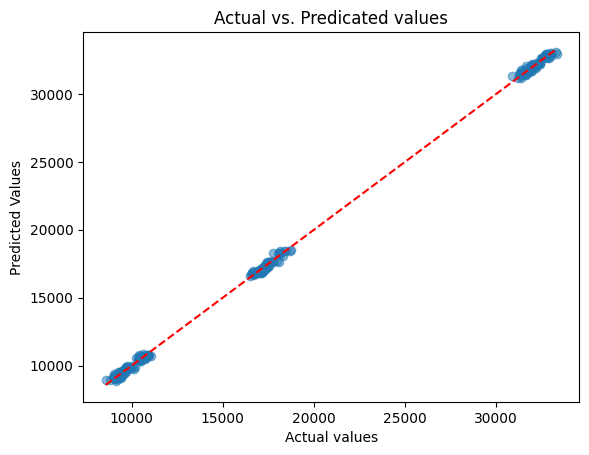

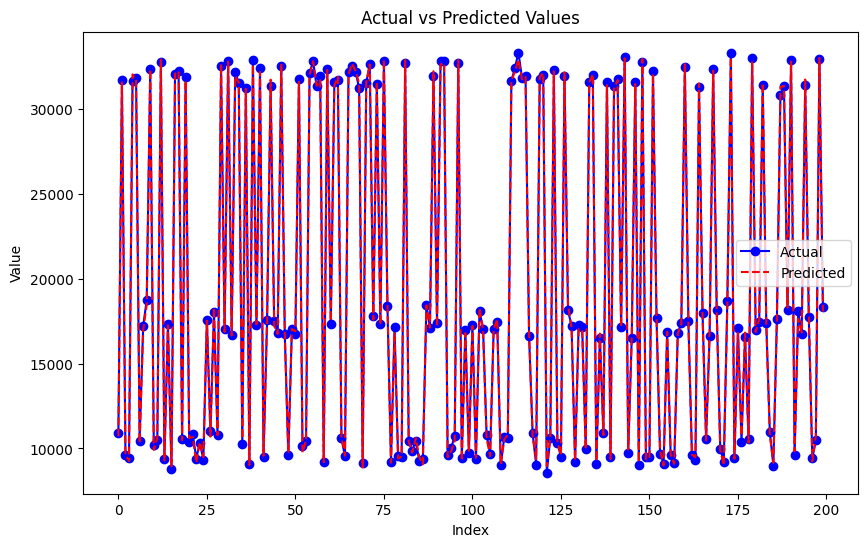

In [11]:
param_grid_linear = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}

predict(LinearRegression(),param_grid_linear)

### **Decision Tree Regressor**

Model is DecisionTreeRegressor(random_state=42)
Fitting 3 folds for each of 9 candidates, totalling 27 fits
R2 Score 0.9995855798199685
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
R2 Score on Training Data: 1.00
R2 Score on Test Data: 1.00
Cross Val score  [0.99944872 0.99942446 0.99940474] 0.9994259724673249 1.798615811117121e-05
Best Params to use  {'max_depth': None, 'min_samples_leaf': 15, 'min_samples_split': 2}
Mean Absolute error: 158.646822
Root Mean Squared error: 193.979182
The model is performing normally.


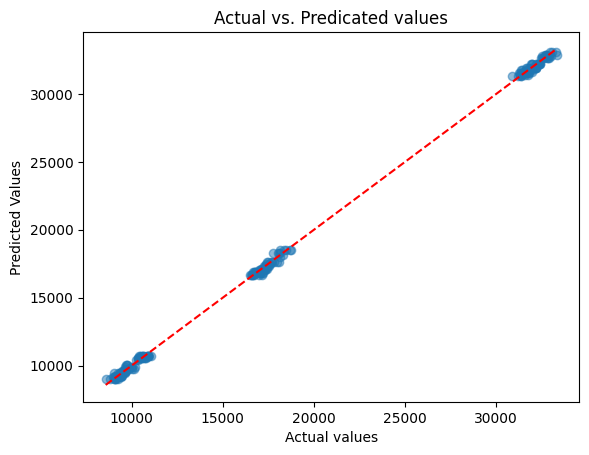

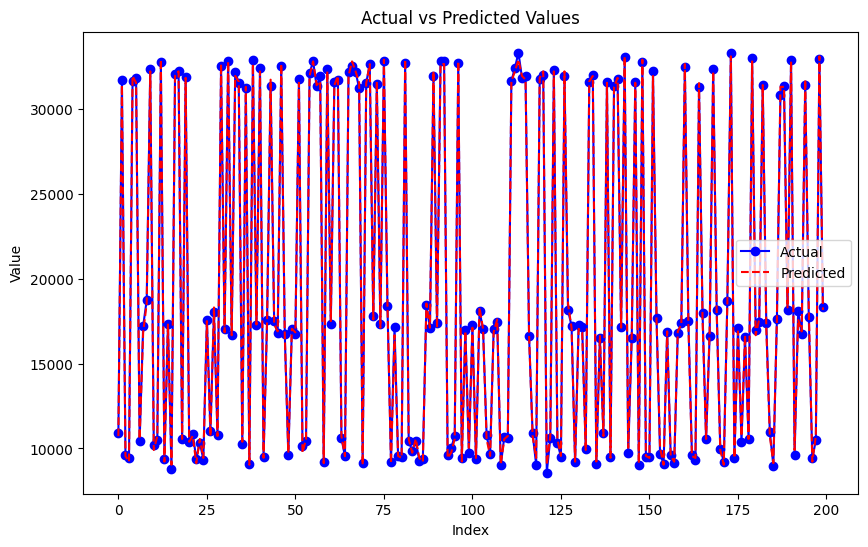

In [12]:
param_grid_dt = {
    'max_depth': [None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [5, 10, 15]
}

predict(DecisionTreeRegressor(random_state=42), param_grid_dt)

### **Random Forest Regressor**

Model is RandomForestRegressor()
Fitting 3 folds for each of 36 candidates, totalling 108 fits
R2 Score 0.9995915807808299
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
R2 Score on Training Data: 1.00
R2 Score on Test Data: 1.00
Cross Val score  [0.99950662 0.99946246 0.99948235] 0.9994838096823088 1.805609616366562e-05
Best Params to use  {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Mean Absolute error: 159.754886
Root Mean Squared error: 192.569615
The model is performing normally.


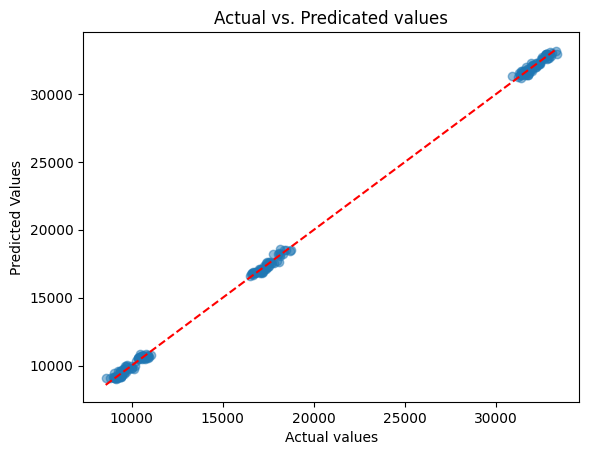

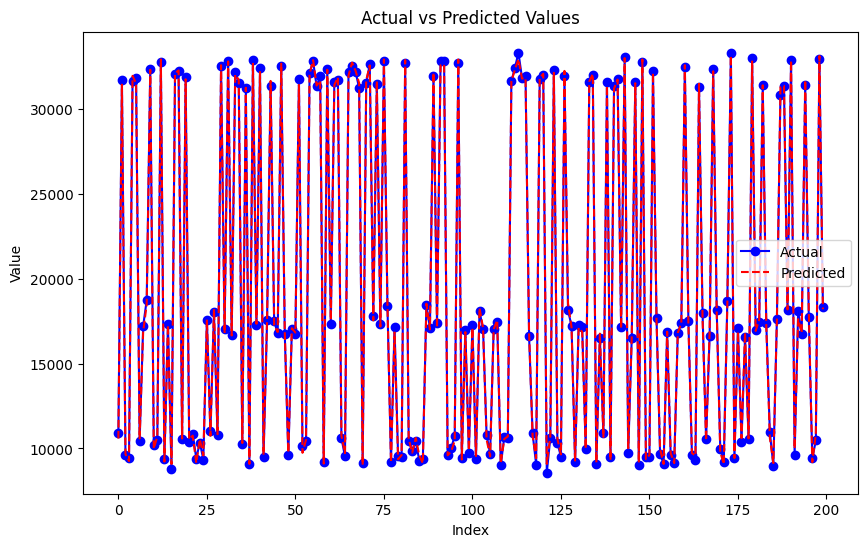

In [13]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [20,30,40],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4]
}

predict(RandomForestRegressor(), param_grid_rf)

### **GradientBoostingRegressor**

Model is GradientBoostingRegressor()
Fitting 3 folds for each of 324 candidates, totalling 972 fits
R2 Score 0.9995831134547315
Fitting 3 folds for each of 324 candidates, totalling 972 fits
Fitting 3 folds for each of 324 candidates, totalling 972 fits
Fitting 3 folds for each of 324 candidates, totalling 972 fits
R2 Score on Training Data: 1.00
R2 Score on Test Data: 1.00
Cross Val score  [0.99950458 0.99946719 0.99952679] 0.9994995231967957 2.4593302409196727e-05
Best Params to use  {'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.8}
Mean Absolute error: 161.772658
Root Mean Squared error: 194.555546
The model is performing normally.


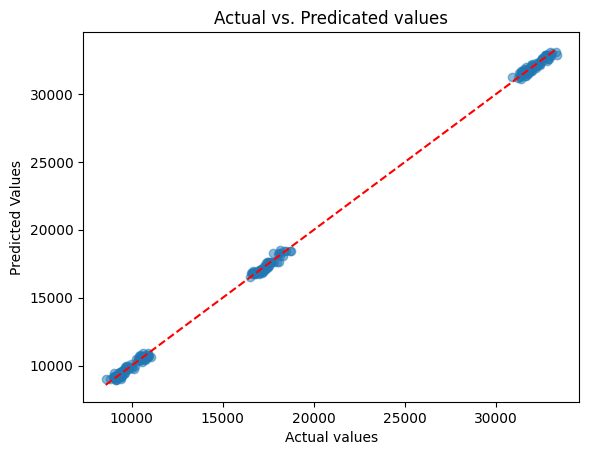

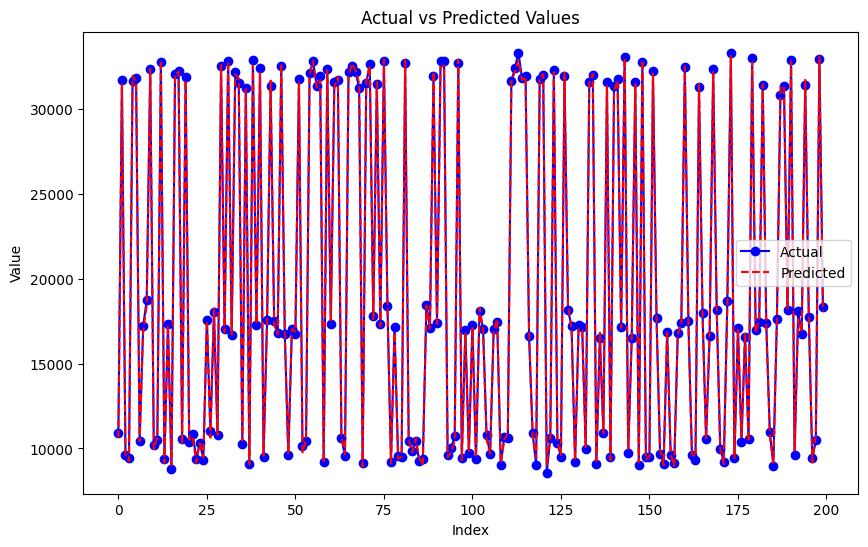

In [14]:
param_grid_gbr = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [2, 3, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9], 
    'loss': ['huber'] 
}

predict(GradientBoostingRegressor(), param_grid_gbr)

### **XGBOOST**

Model is XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
R2 Score 0.9995388572975206
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each

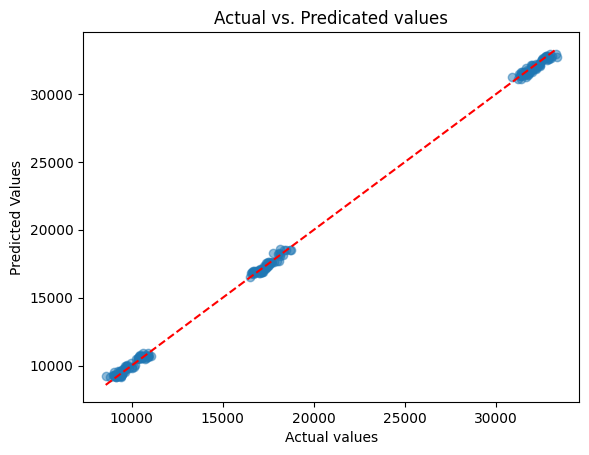

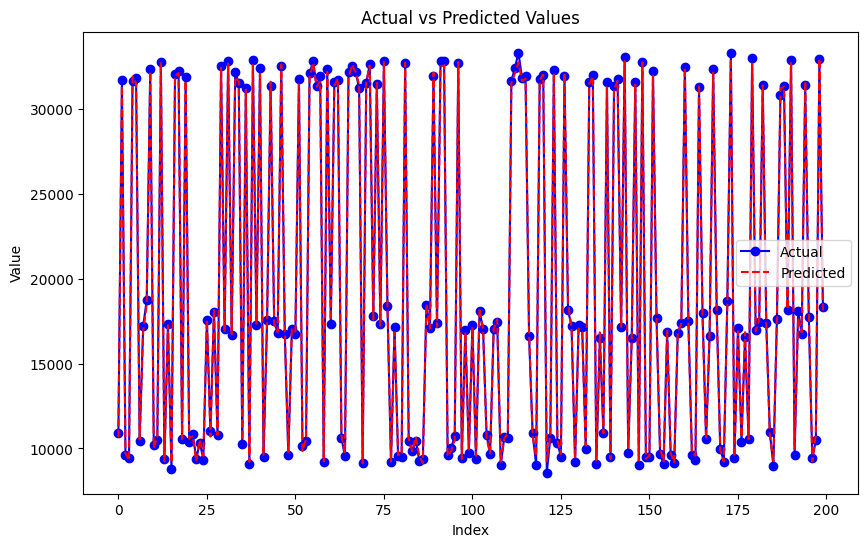

In [16]:
param_grid_xgb = {
    'n_estimators': [300,400,500],
    'max_depth': [5,6,7],
    'learning_rate': [0.01,0.1,0.2],
    'subsample': [0.6, 0.8, 1.0], 
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}
xgb_model = xgb.XGBRegressor()
predict(xgb_model, param_grid_xgb)